#🚀  Festive Boost Inventory Optimization

1️⃣. Project Introduction

📋

Business Problem Statement

Objective: Optimize festive inventory to maximize revenue, reduce stockouts, minimize returns, and improve customer satisfaction.

2️⃣. Data Loading

In [33]:
import pandas as pd
import matplotlib .pyplot as plt
import seaborn as sns
import sqlite3 as sql




Load & Upload All DataFrames

In [34]:
# Initialize SQLite in-memory DB
conn = sql.connect(':memory:')

# step to clean columns
def clean_columns(df):
    df.columns = [col.strip().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]
    return df
# Load all dataframe

# Example: Load your CSV files

product = clean_columns(pd.read_csv("/content/products.csv"))
purchase = clean_columns(pd.read_csv("/content/purchase.csv"))
return_date = clean_columns(pd.read_csv("/content/return_date.csv"))
store = clean_columns(pd.read_csv("/content/store.csv"))
stock = clean_columns(pd.read_csv("/content/stock.csv"))
survey = clean_columns(pd.read_csv("/content/survey.csv"))
sales_date = clean_columns(pd.read_csv("/content/sales_date.csv"))

# Upload to SQLite
sales_date.to_sql('Sales', conn, index=False, if_exists='replace')
stock.to_sql('Stock', conn, index=False, if_exists='replace')
purchase.to_sql('Purchase', conn, index=False, if_exists='replace')
store.to_sql('Store', conn, index=False, if_exists='replace')
survey.to_sql('Survey', conn, index=False, if_exists='replace')
return_date.to_sql('Returns', conn, index=False, if_exists='replace')
sales_date.to_sql('Sales_Date', conn, index=False, if_exists='replace')



20000

# Example Validation Queries (Check Column Names)

In [35]:
tables = ['Sales', 'Stock', 'Purchase', 'Store', 'Survey', 'Returns', 'Sales_Date']
for table in tables:
    query = f"PRAGMA table_info({table});"
    print(f"\nTable: {table}")
    print(pd.read_sql_query(query, conn))



Table: Sales
   cid         name     type  notnull dflt_value  pk
0    0      Sale_ID  INTEGER        0       None   0
1    1     Store_ID  INTEGER        0       None   0
2    2   Product_ID  INTEGER        0       None   0
3    3  Customer_ID  INTEGER        0       None   0
4    4  Employee_ID  INTEGER        0       None   0
5    5     Quantity  INTEGER        0       None   0
6    6   Unit_Price     REAL        0       None   0
7    7    Sale_Date     TEXT        0       None   0
8    8   Store_Type     TEXT        0       None   0

Table: Stock
   cid                        name     type  notnull dflt_value  pk
0    0                  Product_ID  INTEGER        0       None   0
1    1              Stock_Quantity  INTEGER        0       None   0
2    2               Minimum_Level  INTEGER        0       None   0
3    3               Maximum_Level  INTEGER        0       None   0
4    4  Average_Delivery_Time_days  INTEGER        0       None   0

Table: Purchase
   cid           

1️⃣ Stock Reorder Alerts

👉 Identify products approaching minimum stock level to prevent stockouts during festive season.

In [36]:
query = """
SELECT Product_ID, Stock_Quantity, Minimum_Level, Maximum_Level, Average_Delivery_Time_days
FROM Stock
WHERE Stock_Quantity <= Minimum_Level+50;
"""
low_stock_df = pd.read_sql_query(query, conn)

low_stock_df.head()

,Product_ID,Stock_Quantity,Minimum_Level,Maximum_Level,Average_Delivery_Time_days
0,648,37,11,359,17
1,470,57,16,921,2
2,588,60,18,742,3
3,918,27,18,675,15
4,566,45,8,970,13


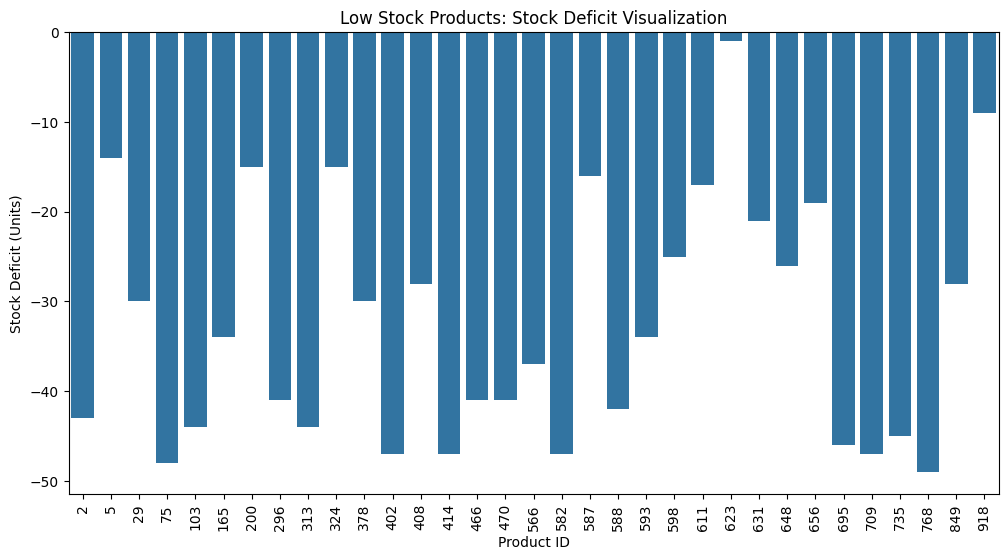

In [37]:


# Check if result has data
if not low_stock_df.empty:
    low_stock_df['Stock_Quantity'] = pd.to_numeric(low_stock_df['Stock_Quantity'], errors='coerce')
    low_stock_df['Minimum_Level'] = pd.to_numeric(low_stock_df['Minimum_Level'], errors='coerce')
    low_stock_df['Stock_Deficit'] = low_stock_df['Minimum_Level'] - low_stock_df['Stock_Quantity']

    plt.figure(figsize=(12,6))
    sns.barplot(data=low_stock_df, x='Product_ID', y='Stock_Deficit')
    plt.title('Low Stock Products: Stock Deficit Visualization')
    plt.xlabel('Product ID')
    plt.ylabel('Stock Deficit (Units)')
    plt.xticks(rotation=90)
    plt.show()

else:
    print("✅ No low-stock products to visualize.")




2️⃣ High Performing Products

👉 Analyze top-selling products during past festive seasons to prioritize for future stock & promotions.

In [38]:
query = """
SELECT Product_ID, SUM(Quantity) AS Total_Sales
FROM Sales
WHERE Sale_Date BETWEEN '2024-10-15' AND '2024-11-15'
GROUP BY Product_ID
ORDER BY Total_Sales DESC
LIMIT 10;
"""

top_products_df = pd.read_sql_query(query, conn)


<Figure size 1200x600 with 0 Axes>

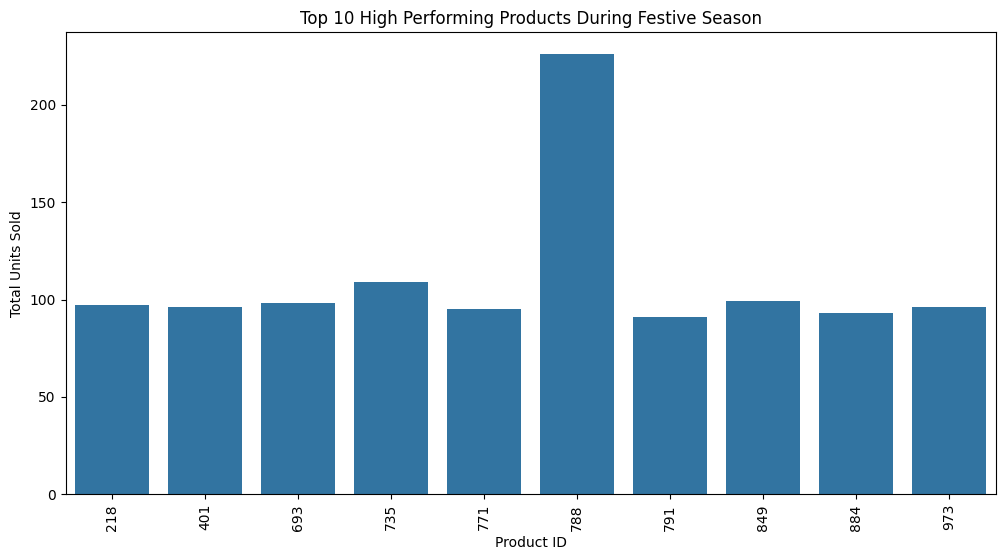

In [39]:
plt.figure(figsize=(12,6))
plt.figure(figsize=(12,6))
sns.barplot(data=top_products_df, x='Product_ID', y='Total_Sales')
plt.title('Top 10 High Performing Products During Festive Season')
plt.xlabel('Product ID')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=90)
plt.show()



3️⃣ Underperforming Products

👉 Identify products with poor sales but high stock → Mark for discount campaigns or delist.

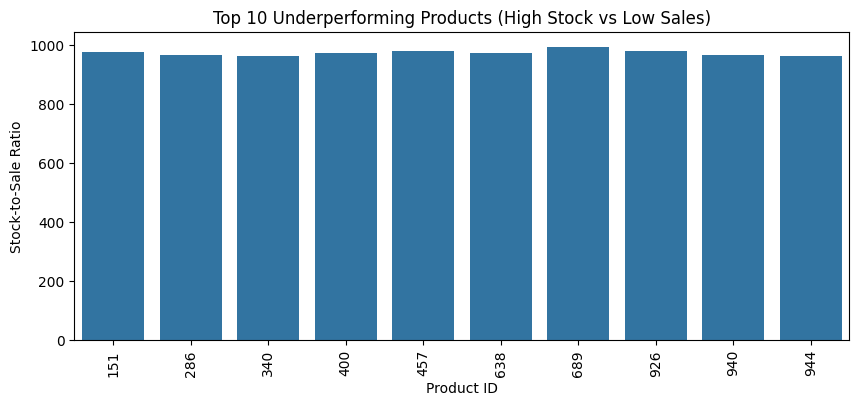

In [40]:



sales_threshold = 10
query = """
SELECT Stock.Product_ID, Stock.Stock_Quantity, IFNULL(SUM(Sales.Quantity), 0) AS Total_Sales
FROM Stock
LEFT JOIN Sales ON Stock.Product_ID = Sales.Product_ID AND Sales.Sale_Date BETWEEN '2024-03-08'  AND '2024-09-08'
GROUP BY Stock.Product_ID, Stock.Stock_Quantity
HAVING Total_Sales < 10 AND Stock_Quantity > 50
ORDER BY Total_Sales ASC;
"""

underperforming_df = pd.read_sql_query(query, conn)

underperforming_df['Stock_to_Sale_Ratio'] = underperforming_df['Stock_Quantity'] / (underperforming_df['Total_Sales'] + 1)

# Select Top 10 worst performers
top_underperformers = underperforming_df.sort_values(by='Stock_to_Sale_Ratio', ascending=False).head(10)

plt.figure(figsize=(10,4))
sns.barplot(data=top_underperformers, x='Product_ID', y='Stock_to_Sale_Ratio')
plt.title('Top 10 Underperforming Products (High Stock vs Low Sales)')
plt.xlabel('Product ID')
plt.ylabel('Stock-to-Sale Ratio')
plt.xticks(rotation=90)
plt.show()





4️⃣ Return Reasons Analysis

👉 Visualize top return reasons to help improve product quality and sizing accuracy.

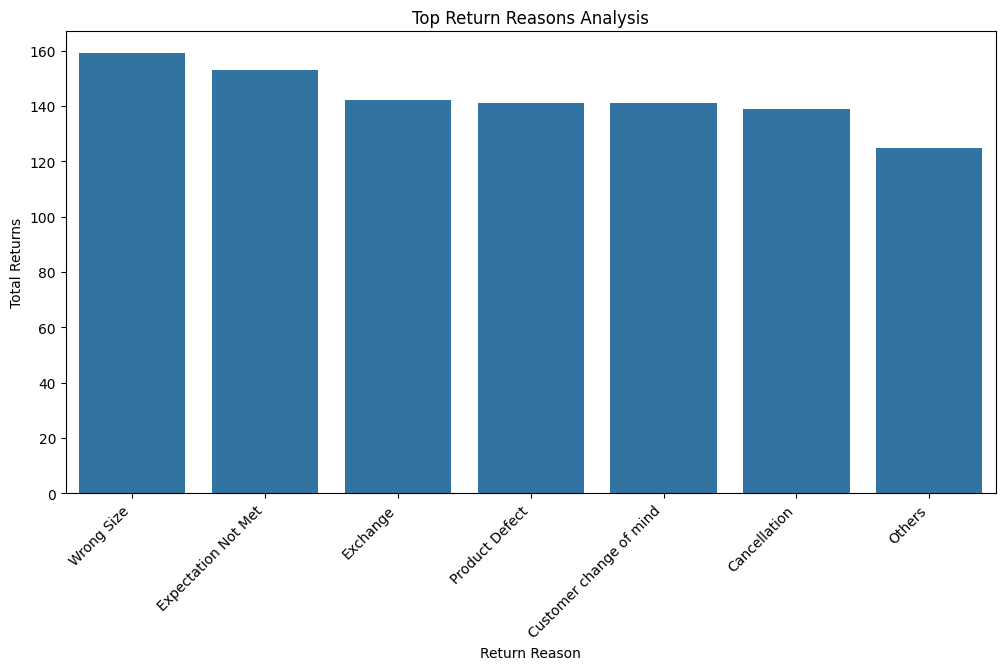

In [41]:
query = """
SELECT Return_Reason, COUNT(Return_ID) AS Total_Returns
FROM Returns
GROUP BY Return_Reason
ORDER BY Total_Returns DESC
LIMIT 10;
"""

return_reasons_df = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
sns.barplot(data=return_reasons_df, x='Return_Reason', y='Total_Returns')
plt.title('Top Return Reasons Analysis')
plt.xlabel('Return Reason')
plt.ylabel('Total Returns')
plt.xticks(rotation=45, ha='right')
plt.show()


5️⃣ Supplier Delivery Performance

👉 Highlight slow suppliers and their average delivery time vs expected delivery → Prevent festive bottlenecks.

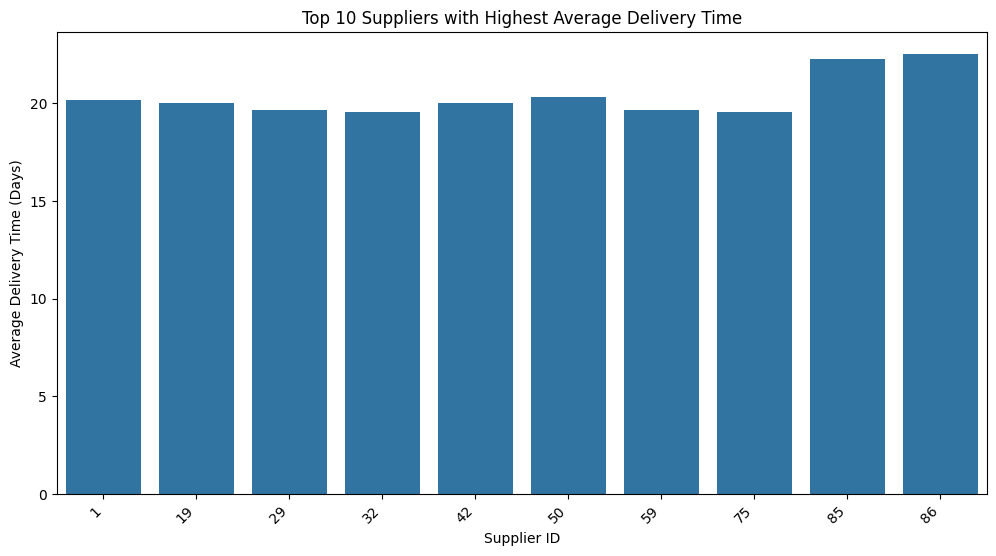

In [42]:
query = """
SELECT Supplier_ID, AVG(Average_Delivery_Time_days) AS Avg_Delivery_Time
FROM Stock inner join Purchase using(Product_ID)
GROUP BY Supplier_ID
ORDER BY Avg_Delivery_Time DESC
LIMIT 10;
"""

supplier_perf_df = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
sns.barplot(data=supplier_perf_df, x='Supplier_ID', y='Avg_Delivery_Time')
plt.title('Top 10 Suppliers with Highest Average Delivery Time')
plt.xlabel('Supplier ID')
plt.ylabel('Average Delivery Time (Days)')
plt.xticks(rotation=45, ha='right')
plt.show()



6️⃣ Sales Trends Over Time

👉 Visualize daily/weekly sales trends during festive periods → Identify peak demand windows.

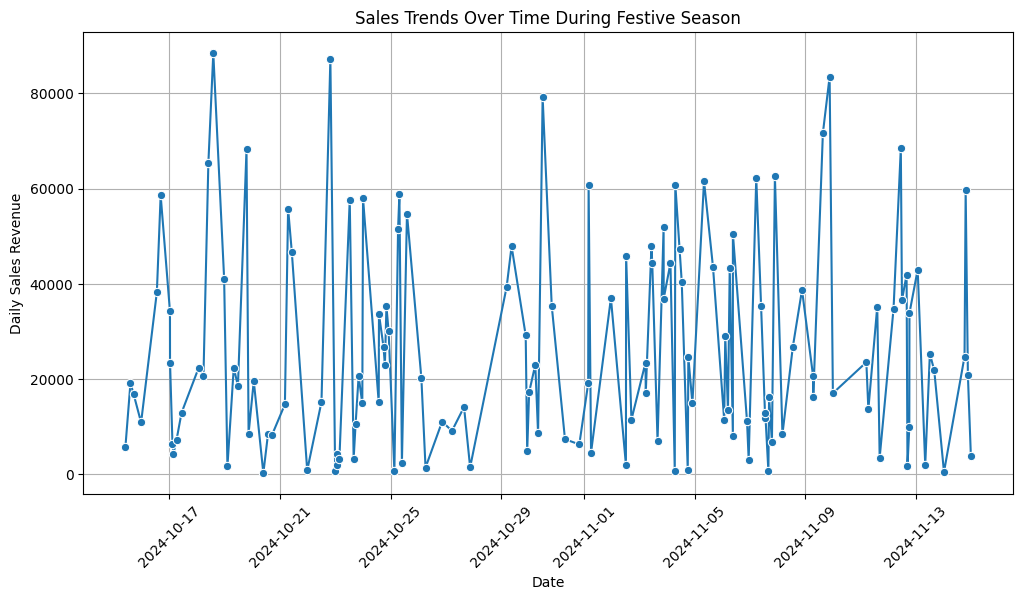

In [43]:
query = """
SELECT Sale_Date, SUM(Quantity * Unit_Price) AS Daily_Sales_Revenue
FROM Sales
WHERE Sale_Date BETWEEN  '2024-10-15' AND '2024-11-15'
GROUP BY Sale_Date
ORDER BY Sale_Date;
"""

sales_trend_df = pd.read_sql_query(query, conn)


sales_trend_df['Sale_Date'] = pd.to_datetime(sales_trend_df['Sale_Date'])

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_trend_df, x='Sale_Date', y='Daily_Sales_Revenue', marker='o')
plt.title('Sales Trends Over Time During Festive Season')
plt.xlabel('Date')
plt.ylabel('Daily Sales Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


7️⃣ Customer Satisfaction vs Sales Correlation

👉 Link survey scores with purchase frequency and repeat customers → Target low-satisfaction customers.

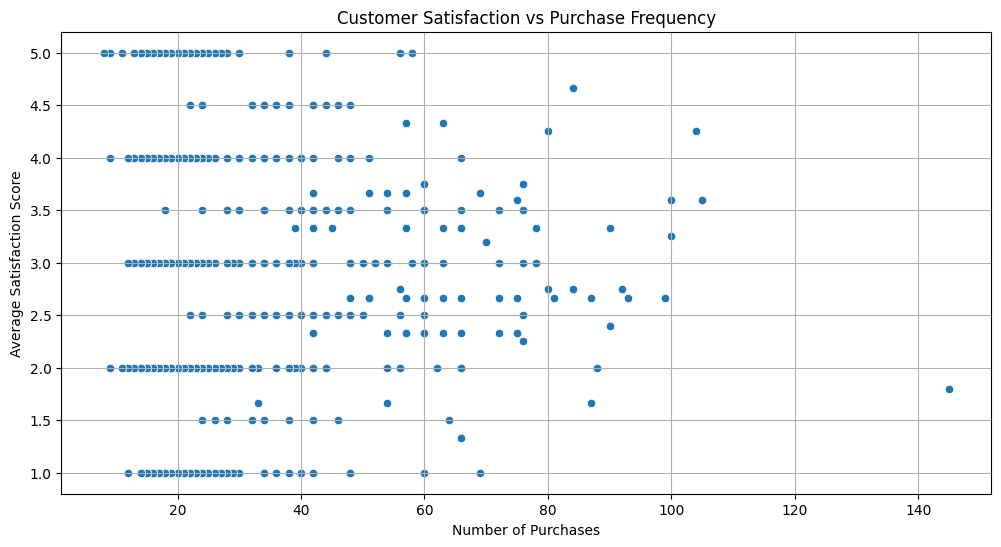

In [44]:
query = """
SELECT S.Customer_ID, AVG(SR.Score) AS Avg_Satisfaction_Score, COUNT(S.Sale_ID) AS Purchase_Count
FROM Sales S
LEFT JOIN Survey SR ON S.Customer_ID = SR.Customer_ID
GROUP BY S.Customer_ID
ORDER BY Purchase_Count DESC;
"""

customer_satisfaction_df = pd.read_sql_query(query, conn)
plt.figure(figsize=(12,6))
sns.scatterplot(data=customer_satisfaction_df, x='Purchase_Count', y='Avg_Satisfaction_Score')
plt.title('Customer Satisfaction vs Purchase Frequency')
plt.xlabel('Number of Purchases')
plt.ylabel('Average Satisfaction Score')
plt.grid(True)
plt.show()

8️⃣ Employee Performance Analysis

👉 Track sales by employee → Identify top performers and those needing support during festive rush.

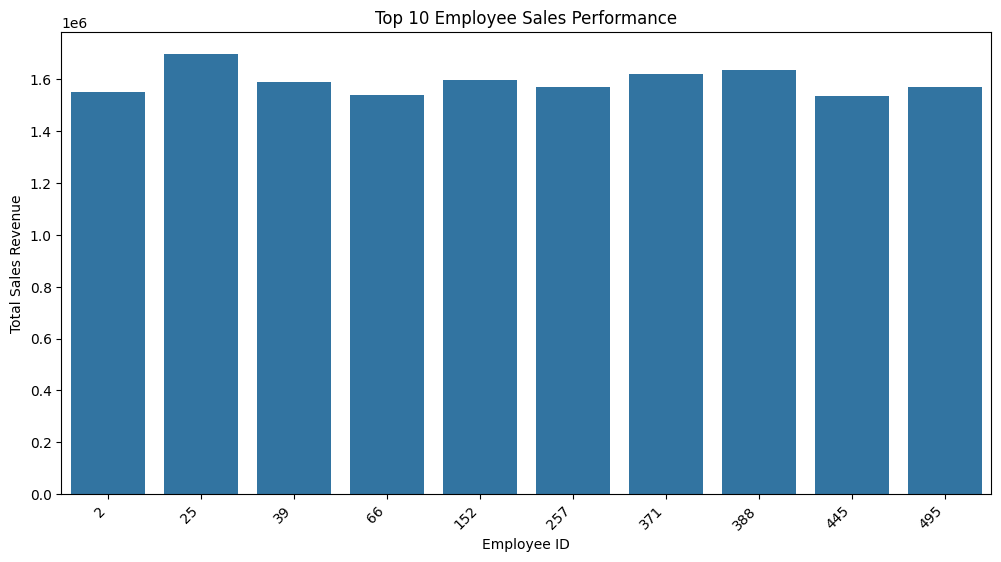

In [45]:
query = """
SELECT Employee_ID, COUNT(Sale_ID) AS Total_Sales_Count, SUM(Quantity * Unit_Price) AS Total_Sales_Revenue
FROM Sales
GROUP BY Employee_ID
ORDER BY Total_Sales_Revenue DESC
LIMIT 10;
"""

employee_perf_df = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
sns.barplot(data=employee_perf_df, x='Employee_ID', y='Total_Sales_Revenue')
plt.title('Top 10 Employee Sales Performance')
plt.xlabel('Employee ID')
plt.ylabel('Total Sales Revenue')
plt.xticks(rotation=45, ha='right')
plt.show()


9️⃣ Regional Sales Comparison

👉 Compare sales performance across regions → Optimize festive stock allocation geographically.

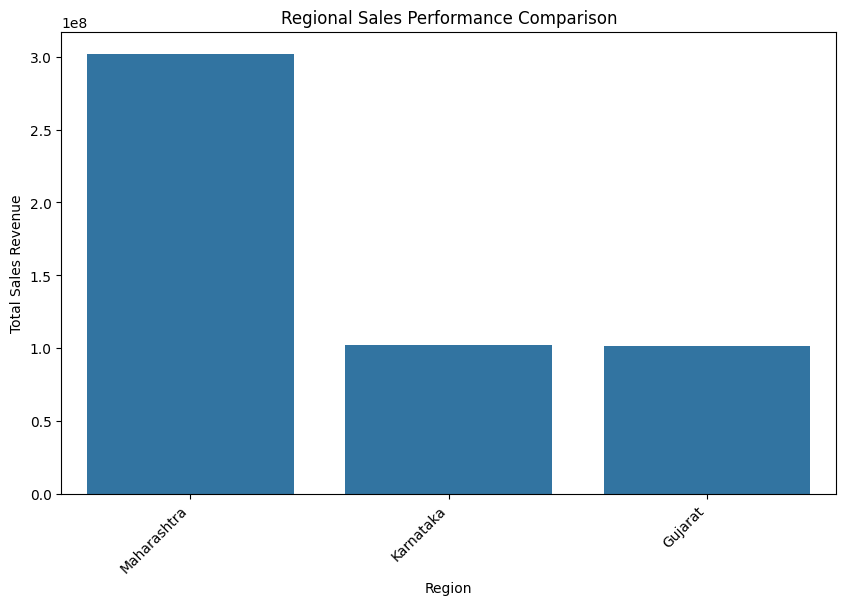

In [46]:
query = """
SELECT St.Region, SUM(S.Quantity * S.Unit_Price) AS Total_Sales_Revenue
FROM Sales S
JOIN Store St ON S.Store_ID = St.Store_ID
GROUP BY St.Region
ORDER BY Total_Sales_Revenue DESC;
"""

region_sales_df = pd.read_sql_query(query, conn)


plt.figure(figsize=(10,6))
sns.barplot(data=region_sales_df, x='Region', y='Total_Sales_Revenue')
plt.title('Regional Sales Performance Comparison')
plt.xlabel('Region')
plt.ylabel('Total Sales Revenue')
plt.xticks(rotation=45, ha='right')
plt.show()

🔟 Product Margin Analysis

👉 Identify products with high sales but low margin → Reprice or focus on high-margin alternatives.

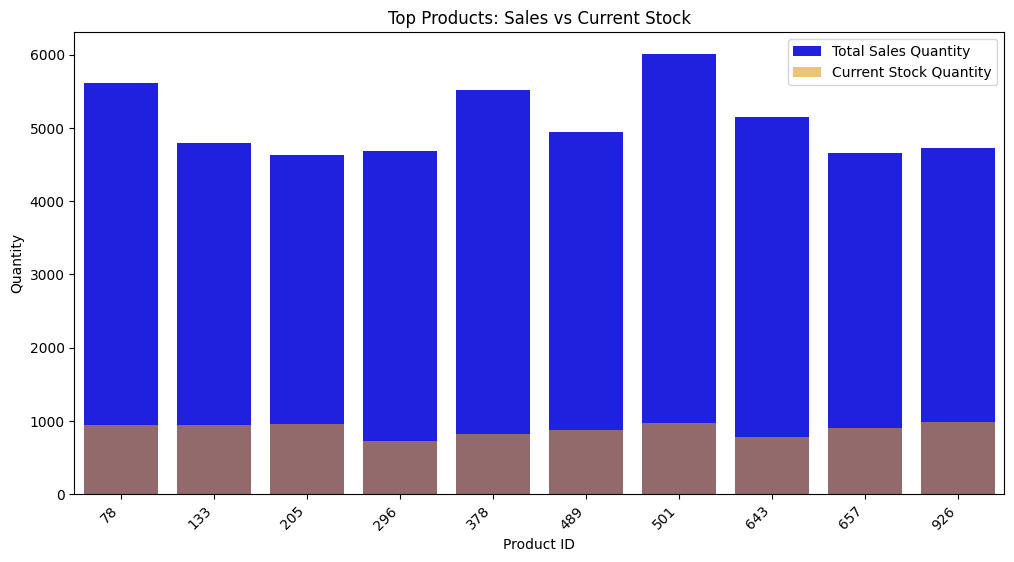

In [47]:
query = """
SELECT S.Product_ID,
       SUM(S.Quantity) AS Total_Sales_Quantity,
       MAX(St.Stock_Quantity) AS Current_Stock_Quantity
FROM Sales S
JOIN Stock St ON S.Product_ID = St.Product_ID
GROUP BY S.Product_ID
ORDER BY Total_Sales_Quantity DESC
LIMIT 10;
"""

product_analysis_df = pd.read_sql_query(query, conn)


plt.figure(figsize=(12,6))
sns.barplot(data=product_analysis_df, x='Product_ID', y='Total_Sales_Quantity', color='blue', label='Total Sales Quantity')
sns.barplot(data=product_analysis_df, x='Product_ID', y='Current_Stock_Quantity', color='orange', alpha=0.6, label='Current Stock Quantity')
plt.title('Top Products: Sales vs Current Stock')
plt.xlabel('Product ID')
plt.ylabel('Quantity')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()


1️⃣1️⃣ Impact of Returns on Sales

👉 Measure the impact of returns on overall revenue → Spot product categories with high return-to-sale ratio.

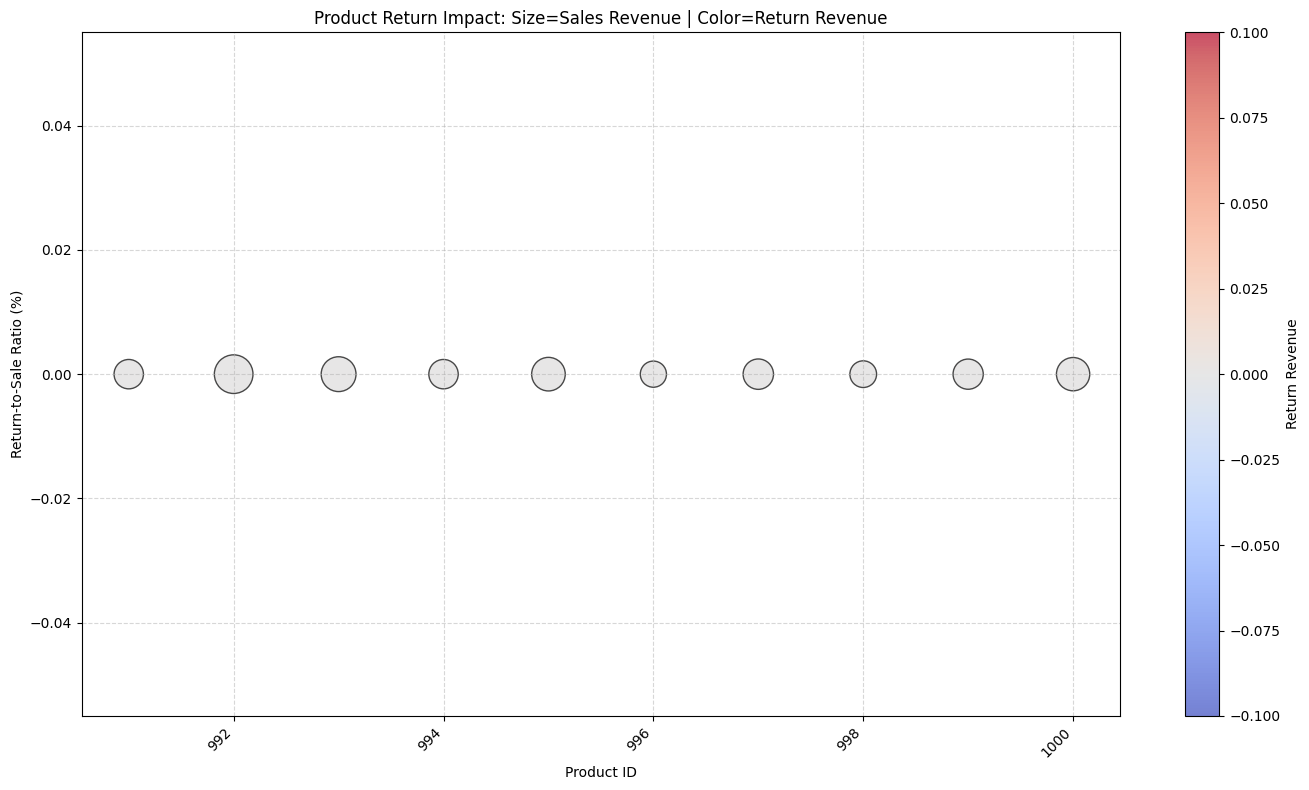

In [48]:
query = """
SELECT S.Product_ID,
       SUM(S.Quantity * S.Unit_Price) AS Total_Sales_Revenue,
       COALESCE(SUM(R.Quantity_Returned * S.Unit_Price), 0) AS Total_Return_Revenue,
       ROUND(
           COALESCE(SUM(R.Quantity_Returned * S.Unit_Price), 0) * 100.0 / SUM(S.Quantity * S.Unit_Price),
           2
       ) AS Return_To_Sale_Percentage
FROM Sales S
LEFT JOIN Returns R ON S.Sale_ID = R.Sale_ID AND S.Product_ID = R.Product_ID
GROUP BY S.Product_ID
ORDER BY Return_To_Sale_Percentage DESC
LIMIT 10;
"""

returns_impact_df = pd.read_sql_query(query, conn)

plt.figure(figsize=(14,8))

sizes = returns_impact_df['Total_Sales_Revenue'] / 1000  # Normalize size

scatter = plt.scatter(
x=returns_impact_df['Product_ID'],
y=returns_impact_df['Return_To_Sale_Percentage'],
s=sizes,
c=returns_impact_df['Total_Return_Revenue'],
cmap='coolwarm',
alpha=0.7,
edgecolors='k'
    )

plt.colorbar(scatter, label='Return Revenue')
plt.title('Product Return Impact: Size=Sales Revenue | Color=Return Revenue')
plt.xlabel('Product ID')
plt.ylabel('Return-to-Sale Ratio (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

1️⃣2️⃣ Predict Next Best Product

👉 Recommend next product to stock based on historical co-purchase patterns → Data-driven cross-sell/up-sell strategy.

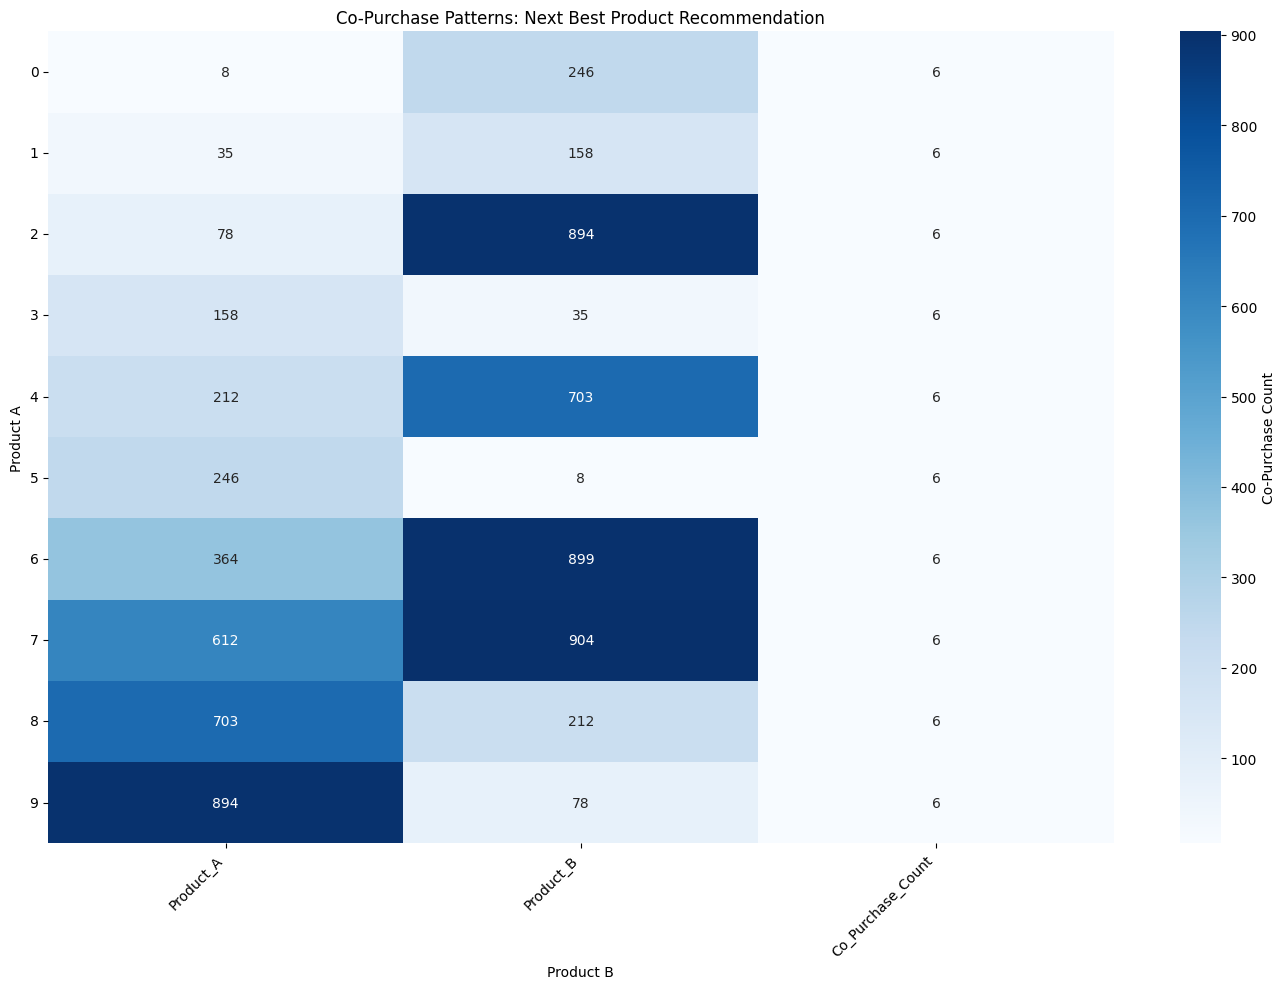

In [49]:
query = """
WITH Customer_Products AS (
    SELECT Customer_ID, GROUP_CONCAT(Product_ID) AS Products_Bought
    FROM Sales
    GROUP BY Customer_ID
)
SELECT sp1.Product_ID AS Product_A, sp2.Product_ID AS Product_B, COUNT(*) AS Co_Purchase_Count
FROM Sales sp1
JOIN Sales sp2 ON sp1.Customer_ID = sp2.Customer_ID AND sp1.Product_ID != sp2.Product_ID
GROUP BY sp1.Product_ID, sp2.Product_ID
ORDER BY Co_Purchase_Count DESC
LIMIT 10;
"""

next_best_df = pd.read_sql_query(query, conn)

plt.figure(figsize=(14,10))
sns.heatmap(next_best_df, annot=True, fmt='.0f', cmap='Blues', cbar_kws={'label': 'Co-Purchase Count'})
plt.title('Co-Purchase Patterns: Next Best Product Recommendation')
plt.xlabel('Product B')
plt.ylabel('Product A')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


1️⃣3️⃣ Seasonal Product Performance Insights

👉 Analyze which products perform best specifically during festive periods vs regular periods → Focus marketing & stock during festive boost.

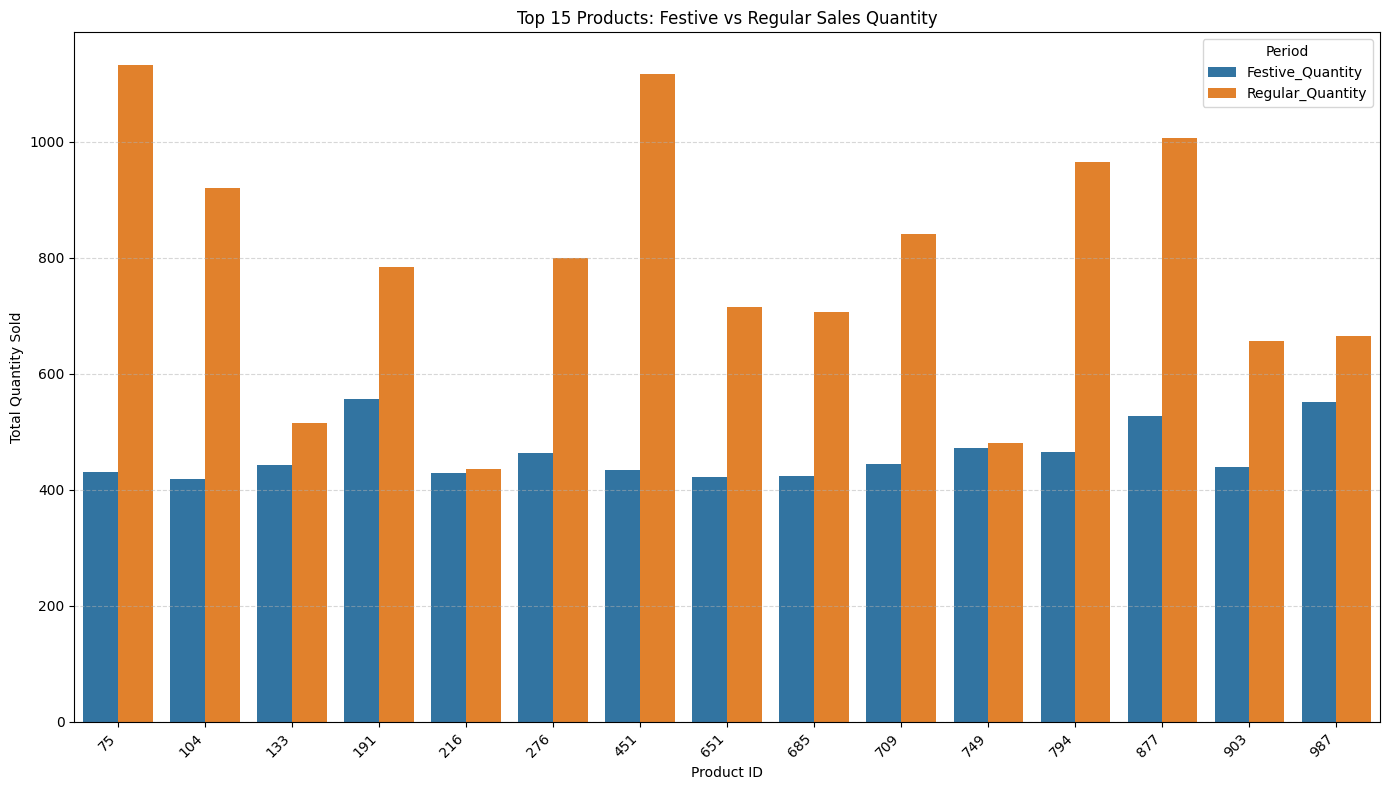

In [50]:
query = """
SELECT
    Product_ID,
    SUM(CASE WHEN strftime('%m', Sale_Date) IN ('10', '11') THEN Quantity ELSE 0 END) AS Festive_Quantity,
    SUM(CASE WHEN strftime('%m', Sale_Date) NOT IN ('10', '11') THEN Quantity ELSE 0 END) AS Regular_Quantity
FROM Sales
GROUP BY Product_ID
ORDER BY Festive_Quantity DESC
LIMIT 15;
"""

seasonal_perf_df = pd.read_sql_query(query, conn)

seasonal_perf_df_melted = seasonal_perf_df.melt(
    id_vars='Product_ID',
    value_vars=['Festive_Quantity', 'Regular_Quantity'],
    var_name='Period',
    value_name='Quantity'
)

plt.figure(figsize=(14,8))
sns.barplot(data=seasonal_perf_df_melted, x='Product_ID', y='Quantity', hue='Period')

plt.title('Top 15 Products: Festive vs Regular Sales Quantity')
plt.xlabel('Product ID')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


1️⃣4️⃣ Customer Churn Prediction Indicator

👉 Identify customers who stopped purchasing after low survey scores or frequent returns → Build simple churn flag to target with re-engagement offers.

/tmp/ipython-input-4209850744.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=churn_df, x='Churn_Flag', palette='Set2')


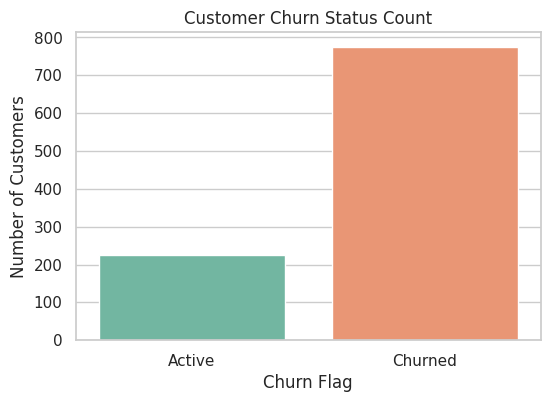

/tmp/ipython-input-4209850744.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=churn_df, x='Churn_Flag', y='Avg_Survey_Score', palette='Set3')


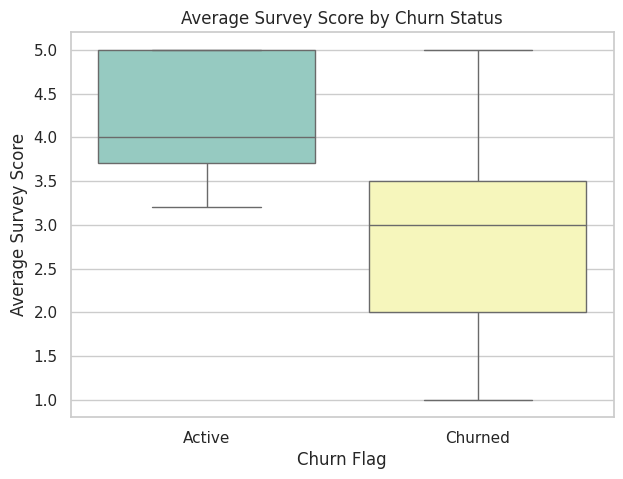

/tmp/ipython-input-4209850744.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=churn_df, x='Churn_Flag', y='Total_Returns', palette='coolwarm')


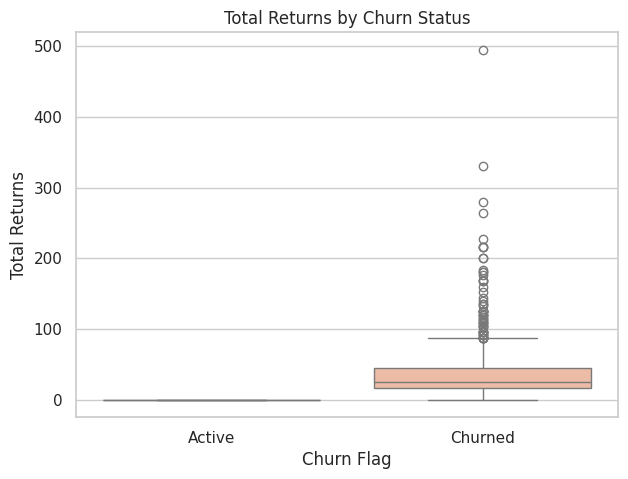

In [51]:
query = """
WITH Customer_Activity AS (
    SELECT s.Customer_ID,
           MAX(Sale_Date) AS Last_Purchase_Date,
           COUNT(r.Return_ID) AS Total_Returns,
           AVG(sv.Score) AS Avg_Survey_Score
    FROM Sales s
    LEFT JOIN Returns r ON s.Customer_ID = r.Customer_ID
    LEFT JOIN Survey sv ON s.Customer_ID = sv.Customer_ID
    GROUP BY s.Customer_ID
)

SELECT Customer_ID,
       Last_Purchase_Date,
       Total_Returns,
       Avg_Survey_Score,
       CASE
           WHEN (Avg_Survey_Score <= 3 OR Total_Returns >= 2) AND Last_Purchase_Date < '2025-08-01' THEN 'Churned'
           ELSE 'Active'
       END AS Churn_Flag
FROM Customer_Activity;
"""

churn_df = pd.read_sql_query(query, conn)



# Set style
sns.set(style="whitegrid")

# 1. Count Plot for Churn vs Active Customers
plt.figure(figsize=(6,4))
sns.countplot(data=churn_df, x='Churn_Flag', palette='Set2')
plt.title('Customer Churn Status Count')
plt.xlabel('Churn Flag')
plt.ylabel('Number of Customers')
plt.show()

# 2. Boxplot: Avg Survey Score by Churn Flag
plt.figure(figsize=(7,5))
sns.boxplot(data=churn_df, x='Churn_Flag', y='Avg_Survey_Score', palette='Set3')
plt.title('Average Survey Score by Churn Status')
plt.xlabel('Churn Flag')
plt.ylabel('Average Survey Score')
plt.show()

# 3. Boxplot: Total Returns by Churn Flag
plt.figure(figsize=(7,5))
sns.boxplot(data=churn_df, x='Churn_Flag', y='Total_Returns', palette='coolwarm')
plt.title('Total Returns by Churn Status')
plt.xlabel('Churn Flag')
plt.ylabel('Total Returns')
plt.show()



1️⃣5️⃣ Excess Stock Clearance Strategy

👉 Detect products consistently unsold across months → Suggest clearance discounts to avoid dead inventory.

/tmp/ipython-input-601557029.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


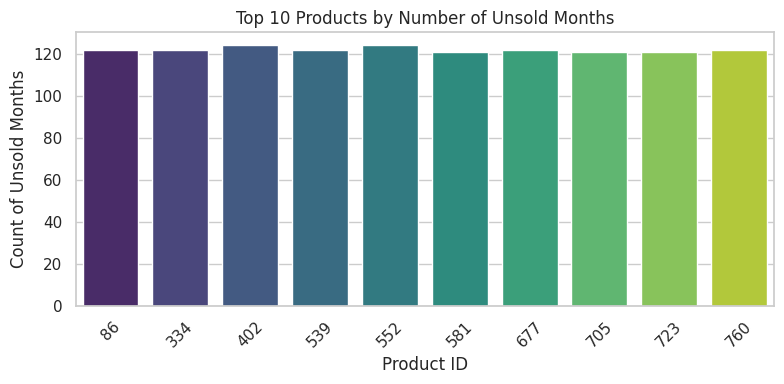

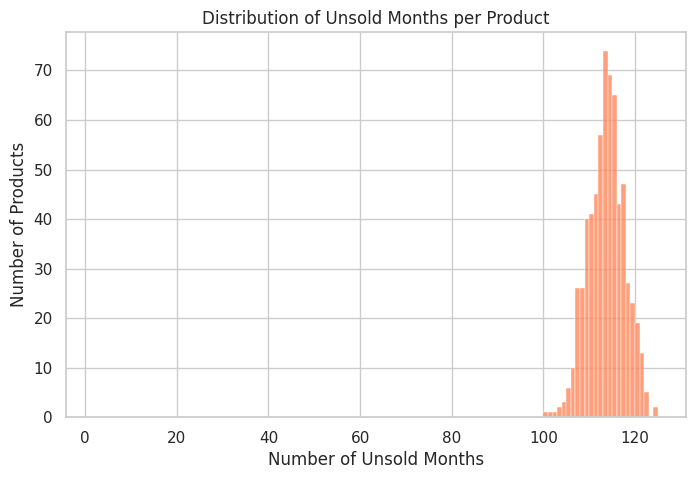

In [52]:


query = """
WITH All_Months AS (
    SELECT DISTINCT strftime('%Y-%m', Sale_Date) AS sale_month
    FROM Sales
),
Product_Month_Cross AS (
    SELECT DISTINCT s.Product_ID, m.sale_month
    FROM Stock s
    CROSS JOIN All_Months m
),
Product_Sales_Months AS (
    SELECT Product_ID, strftime('%Y-%m', Sale_Date) AS sale_month
    FROM Sales
    GROUP BY Product_ID, sale_month
)
SELECT
    pmc.Product_ID,
    COUNT(*) AS Unsold_Months
FROM
    Product_Month_Cross pmc
LEFT JOIN
    Product_Sales_Months psm
ON
    pmc.Product_ID = psm.Product_ID
    AND pmc.sale_month = psm.sale_month
WHERE
    psm.Product_ID IS NULL
GROUP BY
    pmc.Product_ID
HAVING
    Unsold_Months >= 2
ORDER BY
    Unsold_Months DESC;
"""

# Execute query and load into DataFrame
unsold_products_df = pd.read_sql_query(query, conn)

# Load data
unsold_products_df = pd.read_sql_query(query, conn)

# Plot top 10 products with most unsold months
plt.figure(figsize=(8,4))
sns.barplot(
    data=unsold_products_df.head(10),
    x='Product_ID',
    y='Unsold_Months',
    palette='viridis'
)
plt.title('Top 10 Products by Number of Unsold Months')
plt.xlabel('Product ID')
plt.ylabel('Count of Unsold Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution plot of Unsold Months for all qualifying products
plt.figure(figsize=(8,5))
sns.histplot(unsold_products_df['Unsold_Months'], bins=range(2, unsold_products_df['Unsold_Months'].max()+2), kde=False, color='coral')
plt.title('Distribution of Unsold Months per Product')
plt.xlabel('Number of Unsold Months')
plt.ylabel('Number of Products')
plt.show()
